# Galerkin's Method

Compute the discretized solution of the Dirichlet problem for the Poisson equation given by
$$
\begin{cases}
-\Delta u(x,y) = f(x,y) &(x,y) \in \operatorname{int}\Omega\\
u(x,y) = u_{\partial \Omega}(x,y) &(x,y) \in \partial \Omega
\end{cases}
$$
on a pre-generated mesh using a probabilistic linear solver.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
plt.rcParams['figure.dpi'] = 300
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts} \usepackage{amsmath} \usepackage{bm}'

## Mesh Generation and Discretization

We use [FEniCS](https://fenicsproject.org/) to compute the mesh and linear system resulting from the PDE. Installing FEniCS into a Python `virtualenv` can be challenging. To avoid installing FEniCS simply load the linear system from file as we do below. The Python code generating the linear system can be found under `scripts/poisson_pde.py`.

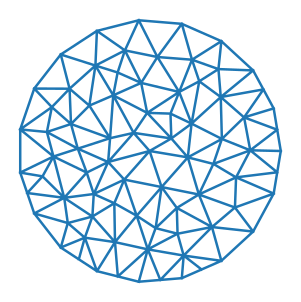

In [2]:
import numpy as np
import scipy.sparse
import matplotlib.tri as tri

# Setup
data_path = "../../data/Galerkins_method/"
plot_path = "../../figures/"

# Load mesh data
mesh_resolution_coarse = 6
mesh_xy = np.load(file=data_path + "mesh_xy_res{}.npy".format(mesh_resolution_coarse))
mesh_cells = np.load(
    file=data_path + "mesh_cells_res{}.npy".format(mesh_resolution_coarse)
)
triang = tri.Triangulation(mesh_xy[:, 0], mesh_xy[:, 1], mesh_cells)

# Plot mesh
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False)
axes[0, 0].triplot(triang, linewidth=2.5)
axes[0, 0].axis("scaled")
axes[0, 0].axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig(plot_path + "PDE_mesh.pdf", bbox_inches="tight", pad_inches=0)

## Linear System via Finite Element Method

In [3]:
# Load linear system from file
A = scipy.sparse.load_npz(file=data_path + "matrix_poisson_res{}.npz".format(mesh_resolution_coarse))
f = np.load(file=data_path + "rhs_poisson_res{}.npy".format(mesh_resolution_coarse))

# print(np.linalg.eigvals(A.todense()))
print(np.linalg.cond(A.todense()))
print("Problem dimension: {}".format(A.shape[0]))

26.515402006200336
Problem dimension: 79


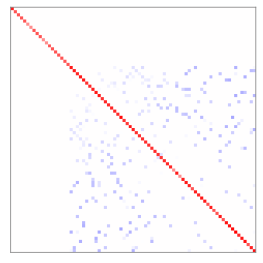

In [4]:
# Plot discretized differential operator
vmax = np.max(np.abs(A.todense()))
vmin = -vmax
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False)
# Plot matrix
axes[0, 0].imshow(A.todense(), cmap="bwr", vmin=vmin, vmax=vmax)
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
# Set axis color
for child in axes[0, 0].get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color("gray")
plt.tight_layout()
plt.savefig(plot_path + "PDE_discr_diffop.pdf", bbox_inches="tight", pad_inches=0)

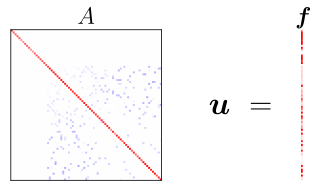

In [5]:
# Plot linear system
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(5, 3),
    sharey=True,
    squeeze=False,
    gridspec_kw={"width_ratios": [4, 0.25, 0.25, 0.25]},
)

#vmax = np.abs(np.max(np.hstack([A.todense(), f[:, None]])))
#vmin = -vmax
axes[0, 0].imshow(A.todense(), cmap="bwr", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("$A$", fontsize=24)
axes[0, 1].text(0.5, A.shape[0] / 2, "$\\bm{u}$", va="center", ha="center", fontsize=32)
axes[0, 1].axis("off")
axes[0, 2].text(0.5, A.shape[0] / 2, "$=$", va="center", ha="center", fontsize=32)
axes[0, 2].axis("off")
axes[0, 3].imshow(f[:, None], cmap="bwr", vmin=vmin, vmax=vmax)
axes[0, 3].set_title("$\\bm{f}$", fontsize=24)
axes[0, 3].axis("off")
for ax in axes[0, :]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## Solution on Fine Mesh

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy
Fine problem dimension: 32957


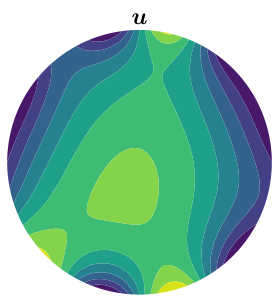

In [6]:
from probnum.linops import SymmetricKronecker
from probnum.random_variables import Normal
from probnum.linalg import problinsolve

# Load linear system from file
mesh_resolution_fine = 128
A_fine = scipy.sparse.load_npz(
    file=data_path + "matrix_poisson_res{}.npz".format(mesh_resolution_fine)
)
f_fine = np.load(file=data_path + "rhs_poisson_res{}.npy".format(mesh_resolution_fine))
print("Fine problem dimension: {}".format(np.shape(A_fine)[0]))

# Solve
usol = scipy.sparse.linalg.spsolve(A_fine, f_fine)

# Save solution to file
np.save(data_path + "solution_res{}".format(mesh_resolution_fine), usol)

# Load solution from file
usol = np.load(file=data_path + "solution_res{}.npy".format(mesh_resolution_fine))

# Load mesh data
mesh_xy_fine = np.load(
    file=data_path + "mesh_xy_res{}.npy".format(mesh_resolution_fine)
)
mesh_cells_fine = np.load(
    file=data_path + "mesh_cells_res{}.npy".format(mesh_resolution_fine)
)


# Interpolation levels and color scaling
interpol_levels = None
vmin_tricont = np.min(usol)
vmax_tricont = np.max(usol)

# Plot solution
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False)
triang_fine = tri.Triangulation(mesh_xy_fine[:, 0], mesh_xy_fine[:, 1], mesh_cells_fine)
plt.tricontourf(
    triang_fine, usol, levels=interpol_levels, vmin=vmin_tricont, vmax=vmax_tricont
)
plt.title("$\\bm{u}$", fontsize=24)
plt.axis("scaled")
plt.axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig(plot_path + "PDE_fine_solution.pdf", bbox_inches="tight", pad_inches=0)

## Solve using a Probabilistic Linear Solver

In [7]:
from probnum.linops import Identity

# Prior distribution on A
n = A.shape[0]
print("Problem dimension: {}".format(n))
covA = SymmetricKronecker(Identity(n))
Ainv0 = Normal(Identity(n), cov=covA)

# Solve linear system
uhat, Ahat, Ainvhat, info_pls = problinsolve(A, f, Ainv0=Ainv0, maxiter=None)
print(info_pls)

# Save solution to file
np.save(data_path + "solution_res{}.npy".format(mesh_resolution_coarse), uhat.mean)

Problem dimension: 79
{'iter': 23, 'maxiter': 790, 'resid_l2norm': 1.9494387118434063e-05, 'trace_sol_cov': 6.986657888182134, 'conv_crit': 'resid_rtol', 'rel_cond': None}


### Estimated Solution

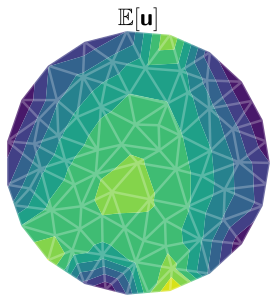

In [8]:
# Load mesh data
mesh_xy = np.load(file=data_path + "mesh_xy_res{}.npy".format(mesh_resolution_coarse))
mesh_cells = np.load(
    file=data_path + "mesh_cells_res{}.npy".format(mesh_resolution_coarse)
)

# Plot mesh and solution
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False)
triang = tri.Triangulation(mesh_xy[:, 0], mesh_xy[:, 1], mesh_cells)
plt.tricontourf(
    triang,
    uhat.mean.ravel(),
    levels=interpol_levels,
    vmin=vmin_tricont,
    vmax=vmax_tricont,
)
plt.triplot(triang, linewidth=2.5, color="white", alpha=0.25)
plt.title("$\mathbb{E}[\\bm{\\mathsf{u}}]$", fontsize=24)
plt.axis("scaled")
plt.axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig(plot_path + "PDE_solution.pdf", bbox_inches="tight", pad_inches=0)

### Estimated Linear Operators

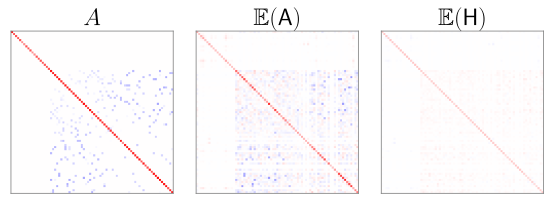

In [9]:
# Plot linear operators
matdict = {
    "$A$": A.todense(),
    "$\mathbb{E}(\mathsf{A})$": Ahat.mean.todense(),
    "$\mathbb{E}(\mathsf{H})$": Ainvhat.mean.todense(),
}

# Set imshow limits uniformly across matrices
vmax = np.max([np.max(np.abs(mat)) for mat in list(matdict.values())])
vmin = -vmax

fig, axes = plt.subplots(
    nrows=1, ncols=len(matdict), figsize=(8, 4), squeeze=False, sharex=True, sharey=True
)
for i, (title, mat) in enumerate(matdict.items()):
    # Plot matrix
    axes[0, i].imshow(mat, cmap="bwr", vmin=vmin, vmax=vmax)
    axes[0, i].set_title(title, fontsize=24)
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    # Set axis color
    for child in axes[0, i].get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color("gray")

plt.tight_layout()
plt.savefig(plot_path + "PDE_operators.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

### Estimated Solution and Samples

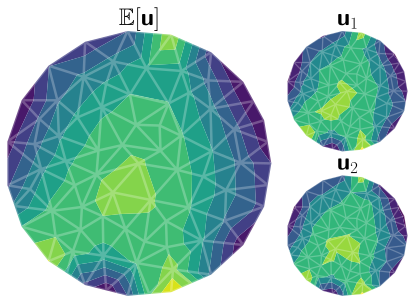

In [10]:
# Sample from Posterior
np.random.seed(42)
n_samples = 2
usamples = uhat.sample(n_samples)

soldict = {
    "$\\bm{\\mathsf{u}}_1$": usamples[0],
    "$\\bm{\\mathsf{u}}_2$": usamples[1],
    # "$\\bm{\hat{u}}_3$" : usamples[2], "$\\bm{\hat{u}}_4$" : usamples[3]
}

# Figure with gridspecs
fig = plt.figure(figsize=(5.8, 4), constrained_layout=False)
gs0 = fig.add_gridspec(1, 2, width_ratios=[2, 1])
gs00 = gs0[0].subgridspec(1, 1, wspace=0)
gs01 = gs0[1].subgridspec(2, 1, wspace=0)

# Estimated solution
fig.add_subplot(gs00[0, 0])
plt.tricontourf(
    triang,
    uhat.mean.ravel(),
    levels=interpol_levels,
    vmin=vmin_tricont,
    vmax=vmax_tricont,
)
plt.triplot(triang, linewidth=2.5, color="white", alpha=0.25)
plt.title("$\mathbb{E}[\\bm{\\mathsf{u}}]$", fontsize=24)
plt.axis("scaled")
plt.axis("off")

# Samples
for i, (title, uvec) in enumerate(soldict.items()):
    fig.add_subplot(gs01[i, 0])
    plt.tricontourf(
        triang, uvec, levels=interpol_levels, vmin=vmin_tricont, vmax=vmax_tricont
    )
    plt.triplot(triang, linewidth=1.25, color="white", alpha=0.25)
    plt.title(title, fontsize=24)
    plt.axis("scaled")
    plt.axis("off")

fig.tight_layout(pad=0, w_pad=0, h_pad=0)

# Save to file
plt.savefig(plot_path + "PDE_solution_samples.pdf", bbox_inches="tight", pad_inches=0.0)

## Error of Solution

Run script ``pde_interpolate_sol.py`` to interpolate the computed solution on the fine grid to the coarse grid. This allows us to compute the error of the approximation and to assess the uncertainty returned by the probabilistic linear solver.

In [11]:
# Load (interpolated) solution from file
u = np.load(file=data_path + "solution_res{}.npy".format(mesh_resolution_coarse))
u_interpol = np.load(
    file=data_path
    + "solution_interpol_res{}tores{}.npy".format(
        mesh_resolution_fine, mesh_resolution_coarse
    )
)

Compute the error, the signed relative error $\lVert u \rVert^{-1}(u - \mathbb{E}[\mathsf{u}])$ and the scaled error $(\Sigma^+)^{-\frac{1}{2}}(u - \mathbb{E}[\mathsf{u}])$, where $\Sigma$ is the covariance matrix of $\mathsf{u}$.

In [12]:
# Compute error
error_u = u_interpol - u
rel_error_u = error_u / np.linalg.norm(u)

# Scaled error
Sigma = uhat.cov.todense()
Sigma_pseudoinv = np.linalg.pinv(Sigma, hermitian=True)
scaled_error_u = np.real_if_close(
    scipy.linalg.sqrtm(Sigma_pseudoinv) @ error_u, tol=10 ** 16
)
print(np.linalg.norm(scaled_error_u))

2.20574504801953


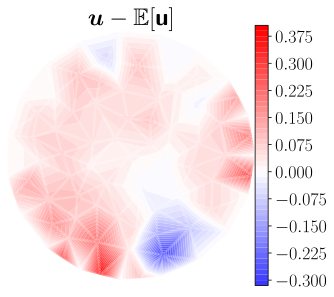

In [13]:
# Load mesh data
mesh_xy = np.load(file=data_path + "mesh_xy_res{}.npy".format(mesh_resolution_coarse))
mesh_cells = np.load(
    file=data_path + "mesh_cells_res{}.npy".format(mesh_resolution_coarse)
)

# Colormap scale
vmax = np.max(np.abs(error_u))
vmin = -vmax

# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4), squeeze=False)
triang = tri.Triangulation(mesh_xy[:, 0], mesh_xy[:, 1], mesh_cells)
tricon = plt.tricontourf(triang, error_u, levels=50, cmap="bwr", vmin=vmin, vmax=vmax)
cbar = plt.colorbar(tricon, pad=0)
cbar.ax.tick_params(labelsize=18)
plt.triplot(triang, linewidth=2.5, color="white", alpha=0.25)
plt.title("$\\bm{u} - \mathbb{E}[\\bm{\\mathsf{u}}]$", fontsize=24)
plt.axis("scaled")
plt.axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

plt.savefig(plot_path + "PDE_error.pdf", bbox_inches="tight", pad_inches=0)

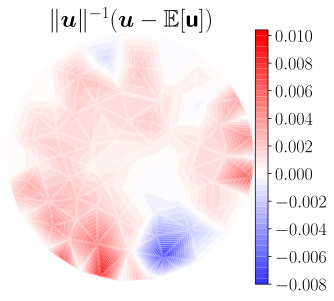

In [14]:
# Colormap scale
vmax = np.max(np.abs(rel_error_u))
vmin = -vmax

# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4), squeeze=False)
triang = tri.Triangulation(mesh_xy[:, 0], mesh_xy[:, 1], mesh_cells)
tricon = plt.tricontourf(
    triang, rel_error_u, levels=50, cmap="bwr", vmin=vmin, vmax=vmax
)
cbar = plt.colorbar(tricon, pad=0)
cbar.ax.tick_params(labelsize=18)
plt.triplot(triang, linewidth=2.5, color="white", alpha=0.25)
plt.title(
    "$\\lVert \\bm{u} \\rVert^{-1} (\\bm{u} - \mathbb{E}[\\bm{\\mathsf{u}}])$",
    fontsize=24,
)
plt.axis("scaled")
plt.axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

plt.savefig(plot_path + "PDE_error_relative.pdf", bbox_inches="tight", pad_inches=0)

## Uncertainty in Solution

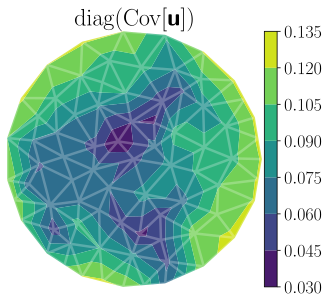

In [15]:
# Solution variance
u_var = np.diag(Sigma)

# Colormap scale
vmax = np.max(np.abs(u_var))
vmin = 0

# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4), squeeze=False)
triang = tri.Triangulation(mesh_xy[:, 0], mesh_xy[:, 1], mesh_cells)
tricon = plt.tricontourf(triang, u_var, cmap="viridis")  # , vmin=vmin, vmax=vmax)
cbar = plt.colorbar(tricon, pad=0)
cbar.ax.tick_params(labelsize=18)
plt.triplot(triang, linewidth=2.5, color="white", alpha=0.25)
plt.title("$\\operatorname{diag}(\\operatorname{Cov}[\\bm{\\mathsf{u}}])$", fontsize=24)
plt.axis("scaled")
plt.axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

plt.savefig(plot_path + "PDE_uncertainty.pdf", bbox_inches="tight", pad_inches=0)

## Uncertainty Calibration

If the uncertainty of the probabilistic linear solver is well calibrated, then the scaled error $(\Sigma^+)^{-\frac{1}{2}}(u - \mathbb{E}[\mathsf{u}])$ is a sample of a standard normal distribution.

In [16]:
# Absolute error
error_u = u_interpol - u

# Scaled error
Sigma = uhat.cov.todense()
Sigma_pseudoinv = np.linalg.pinv(Sigma, hermitian=True)
scaled_error_u = np.real_if_close(
    scipy.linalg.sqrtm(Sigma_pseudoinv) @ error_u, tol=10 ** 16
)

# Scaled error
eps = 10 ** -12
cov = uhat.cov.todense()

# Singular value decomposition
U, s, Uh = scipy.linalg.svd(cov)

# Select numerically non-zero singular values and subset
U = U[:, s > eps]
s = s[s > eps]

# Compute scaled error
scaled_error_u = U @ np.diag(1 / np.sqrt(s)) @ U.T @ error_u

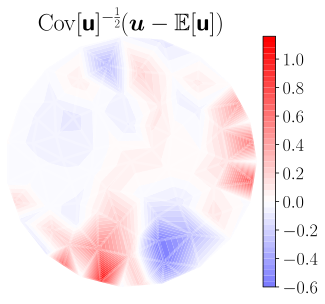

In [17]:
# Colormap scale
vmax = np.max(np.abs(scaled_error_u))
vmin = -vmax

# Plot scaled error
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4), squeeze=False)
triang = tri.Triangulation(mesh_xy[:, 0], mesh_xy[:, 1], mesh_cells)
tricon = plt.tricontourf(
    triang, scaled_error_u, levels=50, cmap="bwr", vmin=vmin, vmax=vmax
)
cbar = plt.colorbar(tricon, pad=0)
cbar.ax.tick_params(labelsize=18)
plt.triplot(triang, linewidth=2.5, color="white", alpha=0.25)
plt.title(
    "$\\operatorname{Cov}[\\bm{\\mathsf{u}}]^{-\\frac{1}{2}} ( \\bm{u} - \mathbb{E}[\\bm{\\mathsf{u}}] )$",
    fontsize=24,
)
plt.axis("scaled")
plt.axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

plt.savefig(
    plot_path + "PDE_uncertainty_calibration.pdf", bbox_inches="tight", pad_inches=0
)